In [1]:
from solve_rg_eqs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def bootstrap_g0_multi(L, g0, kc, imscale_v, final_N=None):
    vs = np.zeros(L)

    Ns = np.arange(2, 4*L, 2)
    if final_N is not None:
        Ns = np.arange(2, final_N+2, 2)
    Ne = Ns[-1]//2
    sols = [None for N in Ns]
    for i, N in enumerate(Ns):
        log('')
        log('Now using {} fermions'.format(N))
        log('')
        n = N//2
        dims = (L, n, n)
        print('Dimensions')
        print(dims)
        # Solving for 2n fermions using extrapolation from previous solution
        if n <= 2:
            force_gs=False
            noise_factors=None
            vars = g0_guess(L, n, n, kc, g0, imscale=imscale_v)
        else:
            # The previous solution matches to roughly the accuracy of the solution
            # for the shared variables
            noise_factors = 10*er*np.ones(len(vars))
            # But we will still need to try random stuff for the 4 new variables
            noise_factors[n-2:n] = 1
            noise_factors[2*n-2:2*n] = 1
            noise_factors[3*n-2:3*n] = 1
            noise_factors[4*n-2:4*n] = 1
        sol = find_root_multithread(vars, kc, g0, dims, imscale_v,
                                    max_steps=MAX_STEPS_1,
                                    use_k_guess=False,
                                    noise_factors=noise_factors,
                                    force_gs=force_gs,
                                    factor=1.1)
        print(vars)
        vars = sol.x
        er = max(abs(rgEqs(vars, kc, g0, dims)))
        log('Error with {} fermions: {}'.format(2*n, er))
        sols[i] = sol
        
        if n%2 == 1:
            # setting up for N divisible by 4 next step
            if n > 1:
                vars = sols[i-1].x # Better to start from last similar case
            n -= 1
            incr = 2
        else:
            incr = 1
        
        if n >= 1:
            es, ws = unpack_vars(vars, n, n)
            vars_guess = g0_guess(L, n+incr, n+incr, kc, g0, imscale=imscale_v)
            esg, wsg = unpack_vars(vars_guess, n+incr, n+incr)
            es = np.append(es, esg[-incr:])
            ws = np.append(ws, wsg[-incr:])
            vars = pack_vars(es, ws)        

    return sols, Ns


def solve_job(prev_vars, kc, g, dims, prev_g):
    sol = root(rgEqs, prev_vars, args=(kc, g, dims), method='lm',
               jac=rg_jac)
    er = np.max(np.abs(sol.fun))
    if er > 10**-6:
        gts = np.linspace(prev_g, g, 4)
        for gt in gts:
            sol = root(rgEqs, prev_vars, args=(kc, gt, dims), method='lm',
                       jac=rg_jac)
            prev_vars = sol.x
    return sol


def solve_job_q(prev_vars, kc, q, dims, prev_q):
    sol = root(rgEqs_q, prev_vars, args=(kc, q, dims), method='lm')
    er = np.max(np.abs(sol.fun))
    if er > 10**-6:
        qts = np.linspace(prev_q, q, 4)
        for qt in qts:
            sol = root(rgEqs_q, prev_vars, args=(kc, qt, dims), method='lm', jac=rg_jac_q)
            prev_vars = sol.x
    return sol


def solve_g_all(l, Ns, g, kc, prev_g, prev_sols):
    dims = [(l, N//2, N//2) for N in Ns]
    with concurrent.futures.ProcessPoolExecutor(max_workers=CPUS) as executor:
        future_results = [executor.submit(solve_job, ps.x, kc, g, dims[Ni], prev_g) for Ni, ps in enumerate(prev_sols)]
        concurrent.futures.wait(future_results)
        for res in future_results:
            try:
                yield res.result()
            except Exception as e:
                print(e)
                
def solve_q_all(l, Ns, g, kc, prev_q, prev_sols):
    dims = [(l, N//2, N//2) for N in Ns]
    with concurrent.futures.ProcessPoolExecutor(max_workers=CPUS) as executor:
        future_results = [executor.submit(solve_job_q, ps.x, kc, q, dims[Ni], prev_q) for Ni, ps in enumerate(prev_sols)]
        concurrent.futures.wait(future_results)
        for res in future_results:
            try:
                yield res.result()
            except Exception as e:
                print(e)

In [3]:
# ls = 2**np.arange(2, 6)
ls = [4]
print(ls)
Ns = [2, 4, 6, 8, 10, 12, 14]
important_G_rats = np.array([0.25, 0.5, 0.75, 1.25, 1.5, 1.75])
real_vars = {l: {N: {Gr: None for Gr in important_G_rats} for N in Ns} for l in ls}
real_ers = {l: {N: {Gr: None for Gr in important_G_rats} for N in Ns} for l in ls}
energies ={l: {N: {Gr: None for Gr in important_G_rats} for N in Ns} for l in ls}

for i, l in enumerate(ls):
    print('')
    print('l = {}'.format(l))
    dg = 0.01/Ns[-1]
    g0 = .1*dg
    imk = dg
    imv = .1*g0 
    
    k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
    kc = np.concatenate((k, imk*(-1)**np.arange(l)))
    Gc = 1./np.sum(k)
    important_gs = G_to_g(important_G_rats*Gc, k)
    important_qs = 1/important_gs

    print('Getting initial solution at g0 = {}'.format(g0))
    sols, Ns = bootstrap_g0_multi(l, g0, kc, imscale_v=imv, final_N=Ns[-1])
    prev_sols = sols
    ers = np.zeros(len(Ns))
    print('Incrementing g with step size {}'.format(dg))
    g = g0 + dg
    prev_g = g0
    G = g_to_G(g, k)
    important_ind = 0
    keep_going = True
    while keep_going and G/Gc < 0.6: # Tends to fail around .75 Gc
        G = g_to_G(g, k)
        print('G/Gc = {}'.format(G*np.sum(k)))
        prev_sols = sols
        for si, s in enumerate(solve_g_all(l, Ns, g, kc, prev_g, sols)):
            sols[si] = s
            ers[si] = np.max(np.abs(s.fun))
            if ers[si] > 10**-7:
                print('High error at N = {}'.format(N))
                print('Variables here')
                print(sols[si].x)
        if max(ers) > 10**-7:
            print('Large error: {}. Switching to q'.format(max(ers)))
            print('Errors:')
            print(ers)
            keep_going = False
            # Will use prev_g, prev_sols on restart
        else:
            # saving previous results in case I need to back up
            prev_g = g
            if g + dg > important_gs[important_ind] and g < important_gs[important_ind]:
                g_imp = important_gs[important_ind]
                for Ni, s in enumerate(sols):
                    N = Ns[Ni]
                    print('Removing im(k) for N = {}'.format(N))
                    dims = (l, N//2, N//2)
                    vars_r, er_r = increment_im_k(s.x, dims, g_imp, k, kc[l:], steps=5*l, max_steps=10, force_gs=False)
                    Gr = important_G_rats[important_ind]
                    real_vars[l][N][Gr] = vars_r
                    real_ers[l][N][Gr] = er_r
                important_ind += 1
            g += dg
    print('!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!')
    print('Finished incrementing g. Now moving to q')
    print('||||||||||||||||||||||||||||||||||||||||')
    print('')
    if not keep_going:
        sols = prev_sols
        g = prev_g
        dq = dg
    else:
        dq = 5*dg
    q = 1/(g + dq)
    prev_q = 1/g
    keep_going = True
    while keep_going and important_ind < len(important_qs):
        G = g_to_G(1/q, k)
        print('G/Gc = {}'.format(G*np.sum(k)))
        for si, s in enumerate(solve_q_all(l, Ns, q, kc, prev_q, sols)):
            sols[si] = s
            ers[si] = np.max(np.abs(s.fun))
            if ers[si] > 10**-7:
                print('High error at N = {}'.format(N))
                print('Variables here')
                print(sols[si].x)
        if max(ers) > 10**-8:
            print('Errors at q = {}:'.format(q))
            print(ers)
            if dq > .05*dg:
                dq *= 0.5
                print('New dq')
                print(dq)
                sols = prev_sols
                q = prev_q + .1*dq
                print('Stepping back to q = {}'.format(q))
            else:
                print('Cannot lower dq. Quitting')
                keep_going = False
        else:
            prev_sols = sols
            if max(ers) < 10**-10::
                if dq < 10*dg:
                    if G/Gc > 1:
                        dq *= 2
                    else:
                        dq *= 1.1 # can't increase too fast here or we'll fail later.
                    print('Max error: {}'.format(max(ers)))
                    print('New dq')
                    print(dq)
            prev_sols = sols
            prev_q = q
            if q - dq < important_qs[important_ind] and q > important_qs[important_ind]:
                q_imp = important_qs[important_ind]
                for Ni, s in enumerate(sols):
                    N = Ns[Ni]
                    print('Removing im(k) for N = {}'.format(N))
                    dims = (l, N//2, N//2)
                    vars_r, er_r = increment_im_k_q(s.x, dims, q_imp, k, kc[l:], steps=5*l)
                    Gr = important_G_rats[important_ind]
                    real_vars[l][N][Gr] = vars_r
                    real_ers[l][N][Gr] = er_r
                important_ind += 1
            q -= dq

[4]

l = 4
Getting initial solution at g0 = 0.000125

Now using 2 fermions

Dimensions
(4, 1, 1)
[0.39267981 0.00125081 0.         0.        ]
Error with 2 fermions: 9.279119694838301e-13

Now using 4 fermions

Dimensions
(4, 2, 2)
Bad initial guess. Trying with noise.
g = 0.000125, er = 0.00021841625683009626
1th try at g = 0.000125
Smallest error from last set: 0.00021841625683009626
Noise ranges from -5.168445013642154e-06 to 1.2913391896370942e-05
[0.39267981 0.39267981 0.00125081 0.00124906 0.39269266 0.39269266
 0.00120998 0.00128998]
Error with 4 fermions: 2.1548203221755103e-12

Now using 6 fermions

Dimensions
(4, 3, 3)
[ 0.39268686  0.39265347  1.17792376  0.00124992  0.00124971 -0.00124807
  0.3926701   0.39267022  0.          0.00125945  0.00124018  0.        ]
Error with 6 fermions: 2.627984940772876e-12

Now using 8 fermions

Dimensions
(4, 4, 4)
Bad initial guess. Trying with noise.
g = 0.000125, er = 0.00021559341908422428
1th try at g = 0.000125
Smallest error from las

In [7]:
print(real_ers[4][8])

{0.25: 3.0156370313135567e-15, 0.5: 1.6962958301138756e-15, 0.75: 7.73914556833241e-09, 1.25: 6.661338147750939e-16, 1.5: 8.881784197001252e-16, 1.75: 1.3322676295501878e-15}


In [35]:
for li, l in enumerate(ls):
    k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
    Gs = np.array(important_G_rats)/np.sum(k)
    for N in Ns:
        for Gr in important_G_rats:
            dims = (l, N//2, N//2)
            vars_r = real_vars[l][N][Gr]
            varss = np.transpose(np.array([vars_r]))
            g = G_to_g(Gr*np.sum(k), k)       
            energy, _ = calculate_energies(dims, [g], k, varss)
            energies[l][N][Gr] = energy

Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy
Calculating R_k, energy


In [71]:
def Z(a,b):
    return a*b/(a-b)

def find_energy(g, ks, es):
    l = len(ks)
    Rs = np.zeros(l)
    for i, k in enumerate(ks):
        Rs[i] = g * np.sum(Z(k, es))
    const = 3*g*np.sum(ks**2)/(1+g*np.sum(ks))
    energy = np.sum(ks*Rs)*2/(1+g*np.sum(ks)) - const
    return energy

In [79]:
for li, l in enumerate(ls):
    k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
    Gs = np.array(important_G_rats)/np.sum(k)
    for N in Ns:
        for Gr in important_G_rats:
            dims = (l, N//2, N//2)
            vars_r = real_vars[l][N][Gr]
            es, ws = unpack_vars(vars_r, N//2, N//2)
            g = G_to_g(Gr/np.sum(k), k)  
            print(N)
            print(g)
            print(Gr)
            energies[l][N][Gr] = find_energy(g, k, es)


2
0.05305164769729845
0.25
2
0.15915494309189535
0.5
2
0.477464829275686
0.75
2
-0.7957747154594768
1.25
2
-0.477464829275686
1.5
2
-0.37136153388108906
1.75
4
0.05305164769729845
0.25
4
0.15915494309189535
0.5
4
0.477464829275686
0.75
4
-0.7957747154594768
1.25
4
-0.477464829275686
1.5
4
-0.37136153388108906
1.75
6
0.05305164769729845
0.25
6
0.15915494309189535
0.5
6
0.477464829275686
0.75
6
-0.7957747154594768
1.25
6
-0.477464829275686
1.5
6
-0.37136153388108906
1.75
8
0.05305164769729845
0.25
8
0.15915494309189535
0.5
8
0.477464829275686
0.75
8
-0.7957747154594768
1.25
8
-0.477464829275686
1.5
8
-0.37136153388108906
1.75


/Users/wholdhus/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


0.25
2
-0.7782317066440162
4
-0.01487201254090631
6
2.094765382970597
8
4.165777752821973
0.5
2
-2.365464551478543
4
-1.6623779404416492
6
-0.04970983282864072
8
1.5028177997604164
0.75
2
-4.0656311633138555
4
-3.5314796741104164
6
-2.7163059347624223
8
-1.9303660869658943
1.25
2
-8.602075921475674
4
-9.485389677065335
6
-10.315269742736835
8
-11.16116278088184
1.5
2
-11.099136919256182
4
-12.951568760399406
6
-14.669600738755815
8
-16.427102792232446
1.75
2
-13.626683224107989
4
-16.480174450483048
6
-19.108059420684487
8
-21.800109672819236


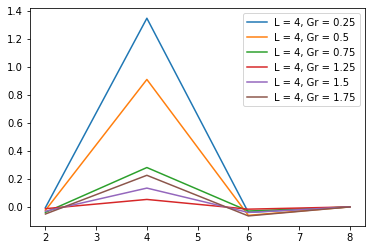

In [85]:
for Gr in important_G_rats:
    print(Gr)
    for N in Ns:
        print(N)
        print(energies[4][N][Gr])
for l in ls:
    for Gr in important_G_rats:
        k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
        G = Gr/np.sum(k)
        if Ns[-1] == 4*l-2:
            gaps = np.zeros(len(Ns))
            final_ind = -1
        else:
            gaps = np.zeros(len(Ns-1)) # can't fill in the last gap
            final_ind = len(Ns) - 1
        for Ni, N in enumerate(Ns[:final_ind]):
            if N == 4*l - 2:
                Ep =4*np.sum(k)-3*G*np.sum(k**2)-4*G*(np.sum(k))**2
            else:
                Ep = energies[l][N+2][Gr]
            E = energies[l][N][Gr]
            if Ni == 0:
                Em = -3*G*np.sum(k**2)
            else:
                Em = energies[l][N-2][Gr]
            gaps[Ni] = Ep + Em - 2*E
        plt.plot(Ns,gaps, label='L = {}, Gr = {}'.format(l, Gr))
    plt.legend()

In [81]:
Grs = important_G_rats
for Gr in Grs:
    print(Gr)
    print(real_vars[4][2][Gr])

0.25
[3.84010464e-01 5.51824068e-34 0.00000000e+00 0.00000000e+00]
0.5
[3.63520358e-01 3.52648305e-38 0.00000000e+00 0.00000000e+00]
0.75
[ 2.86563370e-01 -1.47897539e-29  0.00000000e+00  0.00000000e+00]
1.25
[-4.35406375e-01 -5.11126984e-33  0.00000000e+00  0.00000000e+00]
1.5
[-9.10810557e-01 -9.25971789e-31  0.00000000e+00  0.00000000e+00]
1.75
[-1.40145739e+00  5.83571151e-23  5.74077282e-42  2.94902167e-45]


Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Closest energy difference
7.771561172376096e-16
0
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Closest energy difference
4.440892098500626e-16
0
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Closest energy difference
0.0
0
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Closest energy difference
0.0
0
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Closest energy difference
0.0
0
Hermiticity check passed!
Symmetry checks passed!
Particle conservation check passed!
Closest energy difference
1.0658141036401503e-14
0


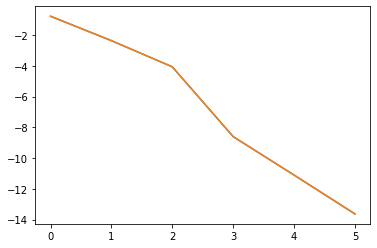

In [84]:
from exact_diag import ham_op_2, form_basis
l = 4
N = 2
basis = form_basis(2*l, N//2, N//2)
k = np.arange(1, 2*l+1, 2)*0.5*np.pi/l
ees = np.zeros(len(Grs))
ebs = np.zeros(len(Grs))
for Gi, Gr in enumerate(Grs):
    G = Gr/np.sum(k)
    h = ham_op_2(l, G, k, basis)
    e, v = h.eigh()
    print('Closest energy difference')
    E0 = energies[4][N][Gr]
    print(np.min(np.abs(e-E0)))
    print(np.argmin(np.abs(e-E0)))
    ees[Gi] = e[0]
    ebs[Gi] = E0
plt.plot(ees)
plt.plot(ebs)


# 